# Notebook to showcase the usage of the eo_processing package
In this notebook we will create for a test area Sentinel-1 & Sentinel-2 time series datacubes which will allow various kind of analysis. The S1/S2 preprocessing pipelines are highly adaptable but also produce with the standard settings best results.
In a second step, we show how to transfer the S1 Sigma Naught and S2 reflectance value datacubes into vegetation indices datacubes. 
Last, we will show how to directly generate feature datacubes which can be input into ML approaches.

Note: the eo_processing package can do more and is worth to further explore.

In [1]:
from eo_processing.utils import bbox_area, init_connection, location_visu
from eo_processing.openeo.preprocessing import ts_datacube_extraction 
from eo_processing.openeo.processing import generate_master_feature_cube, generate_S2_indices
from eo_processing.config import get_job_options, get_collection_options, get_advanced_options, get_standard_processing_options
import os
import json
import xarray
import rasterio
from matplotlib import pyplot
from rasterio.plot import show, show_hist

## connect to openEO processing backend

In [2]:
backend = 'cdse' # also possible: terrascope, development, creodias, sentinelhub
# establish the connection to the selected backend
connection = init_connection(backend)

Authenticated using refresh token.


## First use case, extract the time series datacubes of the Sentinel-1 sigma naught and Sentinel-2 reflectance
### init the job, collection and processing options

In [3]:
job_options = get_job_options(provider=backend)
collection_options = get_collection_options(provider=backend)
processing_options = get_standard_processing_options(provider=backend, task='raw_extraction')

In [4]:
# just print for an overview
print(f'job_options: {job_options}')
print(f'collection_options: {collection_options}')
print(f'processing_options: {processing_options}')

job_options: {'driver-memory': '8G', 'driver-memoryOverhead': '5G', 'driver-cores': '1', 'executor-memory': '1500m', 'executor-memoryOverhead': '2500m', 'executor-cores': '1', 'max-executors': '25', 'soft-errors': 'true', 'executor-request-cores': '800m', 'executor-threads-jvm': '7', 'logging-threshold': 'info'}
collection_options: {'S2_collection': 'SENTINEL2_L2A', 'S1_collection': 'SENTINEL1_GRD'}
processing_options: {'provider': 'cdse', 's1_orbitdirection': 'DESCENDING', 'target_crs': 3035, 'resolution': 10.0, 'time_interpolation': False, 'ts_interval': 'dekad', 'SLC_masking_algo': 'mask_scl_dilation', 'S2_bands': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']}


### specify space & time context

In [5]:
# the time context is given by start and end date
start = '2021-01-01'
end = '2022-01-01'   # the end is always exclusive

# the space context is defined as a bounding box dictionary with south,west,north,east and crs
# we take as example the AOI of Slovakia Devin_Lake (wetlands)
AOI = {'east': 4838000, 'south': 2818000, 'west': 4831000, 'north': 2825000, 'crs': 'EPSG:3035'}

area of AOI in km2: 49.0


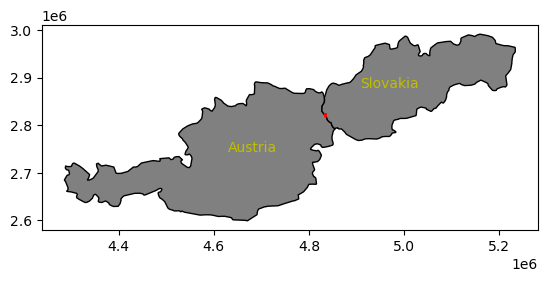

In [6]:
# get area and location print
bbox_area(AOI)
location_visu(AOI, zoom=True, region='EU', label=True)

### get the data from openEO
Note: in these examples we directly extract the data for the given AOI --> maximum area for such requests should not be bigger than 400km2.
      If you want to run bigger areas then you need area spliting by a tiling grid -> see additional example notebooks.

In [7]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 11
out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\eo_processing')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [8]:
# define the openEO pipeline to use
data_cube = ts_datacube_extraction(connection,
                                   AOI,
                                   start,
                                   end,
                                   **collection_options,
                                   **processing_options)

# run the job on openEO as batch job
# NOTE: original time series datacubes as well as time series VI datacubes have 4 dimensions --> save as netCDF
try:
    job = data_cube.execute_batch(title=f'TS datacube extraction AOI - run {str(test_num)}',
                                  description='generation of times series datacube of EO data',
                                  out_format='NetCDF',
                                  job_options=job_options)
            
    # Get the results and save to output file
    results = job.get_results()
    
    outputfile = os.path.join(out_root, f'timeseries_openeo_preprocessed_v{str(test_num)}.nc')
    results.download_file(outputfile)
    # get metadata and job info
    with open(outputfile.replace('.nc','.json'), "w") as outfile:
        json.dump(results.get_metadata(),outfile)
    with open(outputfile.replace('.nc','-job.json'), "w") as outfile:
        json.dump(job.describe_job(),outfile)

except Exception as e:
    print(e)

0:00:00 Job 'j-24100275b9484adbb2494a3583834676': send 'start'
0:00:14 Job 'j-24100275b9484adbb2494a3583834676': created (progress 0%)
0:00:23 Job 'j-24100275b9484adbb2494a3583834676': created (progress 0%)
0:00:38 Job 'j-24100275b9484adbb2494a3583834676': created (progress 0%)
0:00:46 Job 'j-24100275b9484adbb2494a3583834676': created (progress 0%)
0:00:56 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:01:13 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:01:29 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:01:48 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:02:17 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:02:47 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:03:25 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:04:13 Job 'j-24100275b9484adbb2494a3583834676': running (progress N/A)
0:05:12 Job 'j-24100275b9484adbb2494a3583834676': running (progre

NOTE: processing costs on CDSE \
    v1: 20 credits for 49km2 --> 0.4 credits per km2! \
    v2: 11 credits --> 0.22 credits per km2 \
    v3: 10 credits --> 0.2 credits per km2 \
    v4: 10 credits --> 0.2 credits per km2 \
    v5: 12 credits --> 0.25 credits per km2 \
    v6: 10 credits --> 0.2 \
    v7: 10 credits --> 0.2 \
    v8: 13 credits --> 0.26

### visualize the results

In [9]:
# load netCDF
ts1 = xarray.load_dataset(outputfile)
ts1

<xarray.Dataset> Size: 423MB
Dimensions:  (t: 36, x: 700, y: 700)
Coordinates:
  * t        (t) datetime64[ns] 288B 2021-01-01 2021-01-11 ... 2021-12-21
  * x        (x) float64 6kB 4.831e+06 4.831e+06 ... 4.838e+06 4.838e+06
  * y        (y) float64 6kB 2.825e+06 2.825e+06 ... 2.818e+06 2.818e+06
Data variables: (12/13)
    crs      |S1 1B b''
    B02      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 216 180 190 216 209 224 204
    B03      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 237 192 212 231 214 278 274
    B04      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 264 258 302 287 294 344 394
    B05      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 423 454 454 451 451 538 538
    B06      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 572 613 613 625 625 810 810
    ...       ...
    B08      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 777 745 790 802 836 853 870
    B8A      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 817 817 862 862 1117 1117
    B11      (t, y, x) uint16 35MB 0 0 0 0 0 0 ... 1137 1137 1222 1222 1449 1449
    B12      (t, y, x) uint16 35MB 0 0 0 0 0 0 0 ... 814 814 865 865 1074 1074
    VH       (t, y, x) uint16 35MB 2731 2679 2719 2666 ... 65535 65535 65535
    VV       (t, y, x) uint16 35MB 5823 4589 4227 4357 ... 65535 65535 65535
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.40.1a1
    description:  
    title:

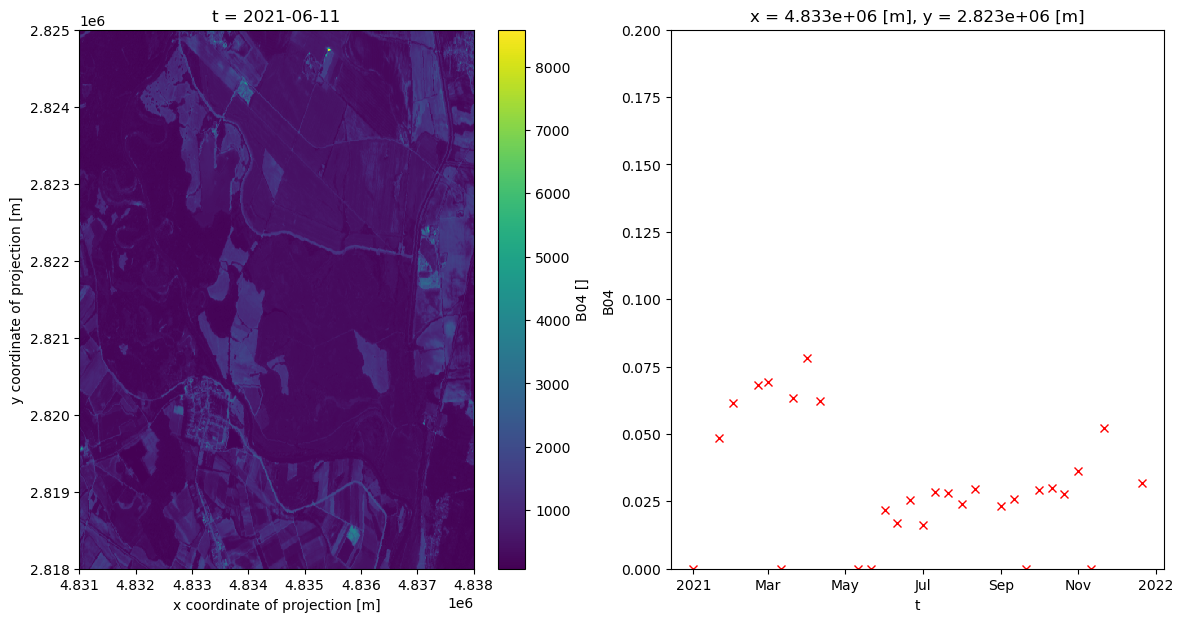

In [10]:
fig, (axb04, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
ts1.B04.sel(t = "2021-06-11").plot(ax=axb04)
(ts1.B04[:,150,150]/10000.).plot(ax=axhist, ylim=(0,0.2), marker='x', color='r', linestyle='')
pyplot.show()

## Second use case, generate the time series cube of the NDVI for Sentinel-2 for the year 2021
Note: in this example we use one of the convinence functions instead using the 'generate_indices_master_cube' and just altering the processing_options
### init the job, collection and processing options

In [9]:
# we use advanced processing options definition to only select the NDVI and the needed S2 bands for that (deactivate append option to only get the NDVI)
processing_options = get_advanced_options(provider=backend, S2_bands=['B04', 'B08'], optical_vi_list=['NDVI'], append=False)

### get the data from openEO

In [10]:
# define the openEO pipeline to use
data_cube = generate_S2_indices(connection,
                                   AOI,
                                   start,
                                   end,
                                   **collection_options,
                                   **processing_options)

# run the job on openEO as batch job
try:
    job = data_cube.execute_batch(title=f'NDVI datacube extraction AOI - run {str(test_num)}',
                                  description='generation of NDVI times series datacube of EO data',
                                  out_format='NetCDF',
                                  job_options=job_options)
            
    # Get the results and save to output file
    results = job.get_results()

    outputfile_vi = os.path.join(out_root, f'NDVI_timeseries_openeo_preprocessed_v{str(test_num)}.nc')
    results.download_file(outputfile_vi)
    # get metadata and job info
    with open(outputfile_vi.replace('.nc','.json'), "w") as outfile:
        json.dump(results.get_metadata(),outfile)
    with open(outputfile_vi.replace('.nc','-job.json'), "w") as outfile:
        json.dump(job.describe_job(),outfile)

except Exception as e:
    print(e)

0:00:00 Job 'j-24100293269444c2a58b160957ab3de4': send 'start'
0:00:13 Job 'j-24100293269444c2a58b160957ab3de4': created (progress 0%)
0:00:19 Job 'j-24100293269444c2a58b160957ab3de4': created (progress 0%)
0:00:25 Job 'j-24100293269444c2a58b160957ab3de4': created (progress 0%)
0:00:41 Job 'j-24100293269444c2a58b160957ab3de4': created (progress 0%)
0:00:51 Job 'j-24100293269444c2a58b160957ab3de4': created (progress 0%)
0:01:12 Job 'j-24100293269444c2a58b160957ab3de4': created (progress 0%)
0:01:27 Job 'j-24100293269444c2a58b160957ab3de4': running (progress N/A)
0:01:52 Job 'j-24100293269444c2a58b160957ab3de4': running (progress N/A)
0:02:16 Job 'j-24100293269444c2a58b160957ab3de4': running (progress N/A)
0:02:53 Job 'j-24100293269444c2a58b160957ab3de4': running (progress N/A)
0:03:33 Job 'j-24100293269444c2a58b160957ab3de4': running (progress N/A)
0:04:19 Job 'j-24100293269444c2a58b160957ab3de4': running (progress N/A)
0:05:22 Job 'j-24100293269444c2a58b160957ab3de4': running (progress

NOTE: processing costs on CDSE \
    v5: 7 credits --> 0.14 credits per km2 \
    v6: 6 credits --> 0.12 \
    v7: 6 credits --> 0.12 \
    v8: 7 credits --> 0.14

### visualize the results

In [100]:
# load netCDF
ts2 = xarray.load_dataset(outputfile_vi)
ts2

<xarray.Dataset> Size: 63MB
Dimensions:  (t: 32, x: 700, y: 700)
Coordinates:
  * t        (t) datetime64[ns] 256B 2021-01-11 2021-01-21 ... 2021-12-21
  * x        (x) float64 6kB 4.831e+06 4.831e+06 ... 4.838e+06 4.838e+06
  * y        (y) float64 6kB 2.825e+06 2.825e+06 ... 2.818e+06 2.818e+06
Data variables:
    crs      |S1 1B b''
    NDVI     (t, y, x) float32 63MB nan nan nan nan ... 0.4796 0.4252 0.3766
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.40.1a1
    description:  
    title:

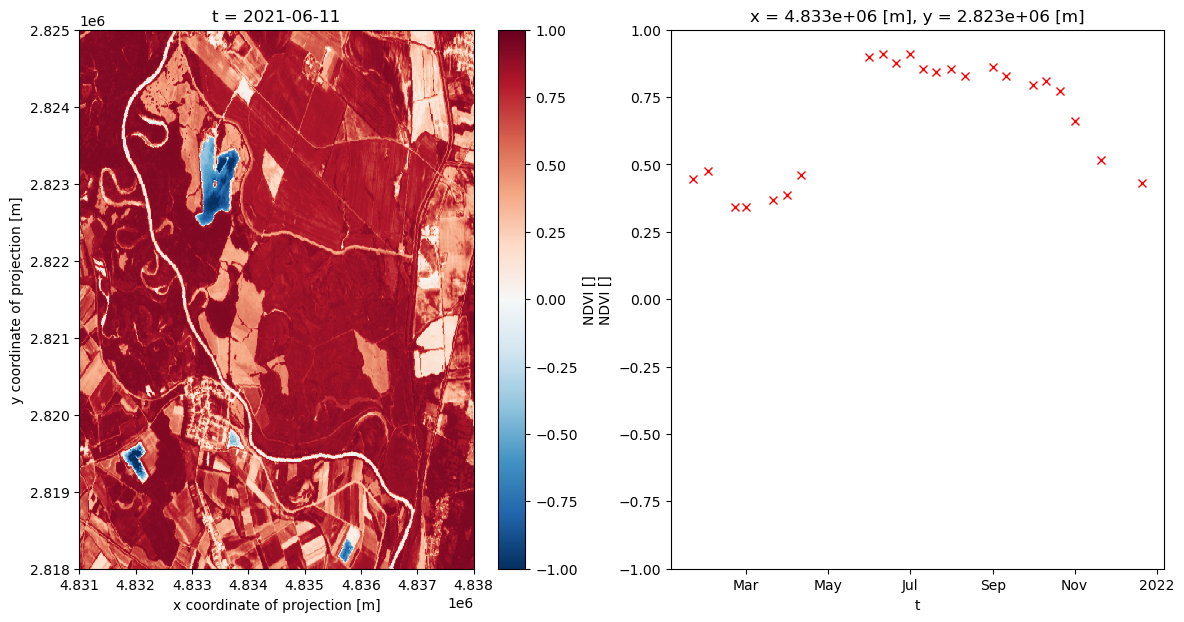

In [101]:
fig, (axNDVI, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
ts2.NDVI.sel(t = "2021-06-11").plot(ax=axNDVI)
ts2.NDVI[:,150,150].plot(ax=axhist, ylim=(-1,1), marker='x', color='r', linestyle='')
pyplot.show()

## Third use case, generate the full feature cube for the year 2021
Note: we use the standard settings which will generate overall 237 features (temporal aggegations of the VI, S2 reflectance and S1 sigma naught)
### init the job, collection and processing options

In [11]:
# we call again the standard processing options for feature generation
processing_options = get_standard_processing_options(provider=backend, task='feature_generation')

### get the data from openEO

In [12]:
# define the openEO pipeline to use
data_cube = generate_master_feature_cube(connection,
                                   AOI,
                                   start,
                                   end,
                                   **collection_options,
                                   **processing_options)

# run the job on openEO as batch job
try:
    job = data_cube.execute_batch(title=f'full feature datacube extraction AOI - run {str(test_num)}',
                                  description='generation of full feature data cube of EO data',
                                  out_format='GTiff',
                                  job_options=job_options)
            
    # Get the results and save to output file
    results = job.get_results()

    outputfile_feature = os.path.join(out_root, f'feature_cube_openeo_preprocessed_v{str(test_num)}.tif')
    results.download_file(outputfile_feature)
    # get metadata and job info
    with open(outputfile_feature.replace('.tif','.json'), "w") as outfile:
        json.dump(results.get_metadata(),outfile)
    with open(outputfile_feature.replace('.tif','-job.json'), "w") as outfile:
        json.dump(job.describe_job(),outfile)

except Exception as e:
    print(e)

0:00:00 Job 'j-241002ad88e046b6ad79177d71cec19a': send 'start'
0:00:15 Job 'j-241002ad88e046b6ad79177d71cec19a': created (progress 0%)
0:00:31 Job 'j-241002ad88e046b6ad79177d71cec19a': created (progress 0%)
0:00:46 Job 'j-241002ad88e046b6ad79177d71cec19a': created (progress 0%)
0:00:54 Job 'j-241002ad88e046b6ad79177d71cec19a': created (progress 0%)
0:01:04 Job 'j-241002ad88e046b6ad79177d71cec19a': created (progress 0%)
0:01:21 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progress N/A)
0:01:36 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progress N/A)
0:01:55 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progress N/A)
0:02:21 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progress N/A)
0:02:52 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progress N/A)
0:03:29 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progress N/A)
0:04:18 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progress N/A)
0:05:17 Job 'j-241002ad88e046b6ad79177d71cec19a': running (progres

NOTE: processing costs on CDSE \
    v5: 7 credits --> 0.14 credits per km2 \
    v6: 14 credits --> 0.28 \
    v7: 13 credits --> 0.26 \
    v8: 13 credits --> 0.26 

### visualize the results

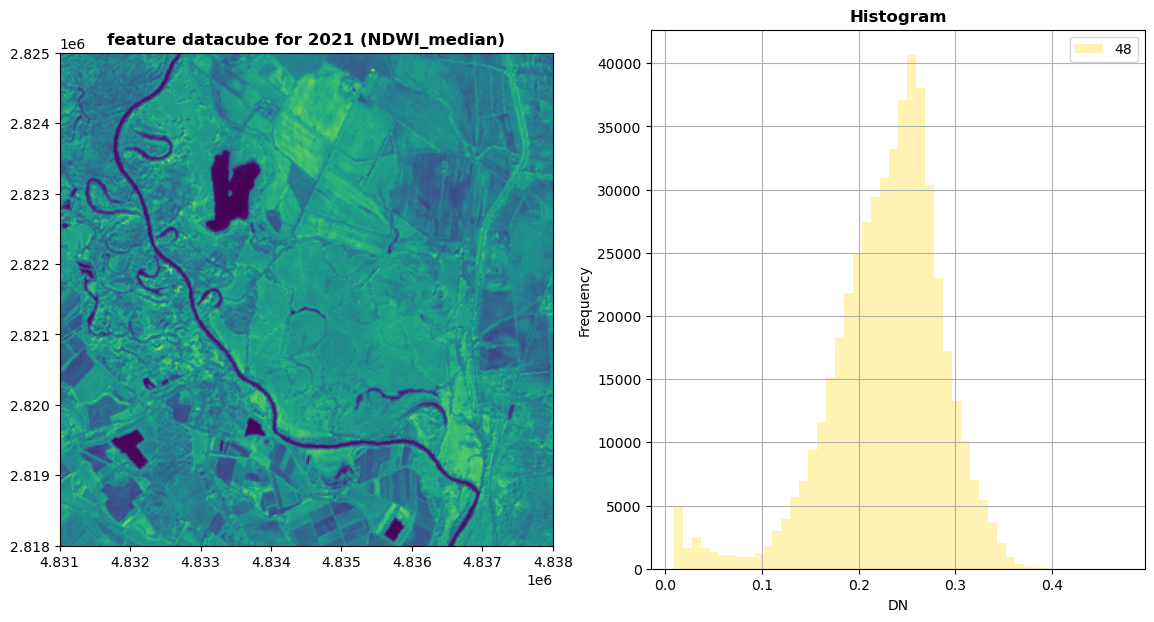

In [109]:
with rasterio.open(outputfile_feature) as src:
    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    show((src,48), with_bounds=True, ax=axrgb, title='feature datacube for 2021 (NDWI_median)')
    show_hist((src,48), bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram", ax=axhist)
    pyplot.show()